# Cosmos-UK Soil Moisture (UKCEH)

{opticon}`tag`
{bdg-primary}`Agriculture`
{bdg-secondary}`Exploration`
{bdg-warning}`Standard`
{bdg-info}`Python`

<p align="left">
    <a href="https://github.com/eds-book-gallery/435f534c-e49b-43c3-9bd6-3393100bef3f/blob/main/LICENSE">
        <img alt="license" src="https://img.shields.io/badge/license-MIT-yellow.svg">
    </a>
    <a href="https://github.com/eds-book-gallery/435f534c-e49b-43c3-9bd6-3393100bef3f/actions/workflows/render.yaml">
        <img alt="render" src="https://github.com/eds-book-gallery/435f534c-e49b-43c3-9bd6-3393100bef3f/actions/workflows/render.yaml/badge.svg">
    </a>
    <a href="https://github.com/alan-turing-institute/environmental-ds-book/pull/50">
        <img alt="review" src="https://img.shields.io/badge/view-review-purple">
    </a>
    <br/>
</p>

<p align="left">
    <a href="http://mybinder.org/v2/gh/eds-book-gallery/435f534c-e49b-43c3-9bd6-3393100bef3f/main?labpath=notebook.ipynb">
        <img alt="binder" src="https://mybinder.org/badge_logo.svg">
    </a>
    <a href="https://replay.notebooks.egi.eu/v2/gh/eds-book-gallery/435f534c-e49b-43c3-9bd6-3393100bef3f/main?labpath=notebook.ipynb">
        <img alt="binder" src="https://img.shields.io/badge/launch-EGI%20binder-F5A252.svg?logo=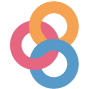">
    </a>
    <br/>
</p>

<p align="left">
    <a href="https://w3id.org/ro-id/435f534c-e49b-43c3-9bd6-3393100bef3f">
        <img alt="RoHub" src="https://img.shields.io/badge/RoHub-FAIR_Executable_Research_Object-2ea44f?logo=Open+Access&logoColor=blue">
    </a>
    <a href="https://zenodo.org/badge/latestdoi/493432867">
        <img alt="doi" src="https://zenodo.org/badge/493432867.svg">
    </a>
</p>

## Context
### Purpose
To load and visualise daily hydrometeorological and soil data from the [2013-2019 public COSMOS-UK dataset](https://doi.org/10.5285/b5c190e4-e35d-40ea-8fbe-598da03a1185).

### Sensor description
Since 2013 the UK Centre for Ecology & Hydrology (UKCEH) has established the world’s most spatially dense national network of cosmic-ray neutron sensors (CRNSs) to monitor soil moisture across the UK. The Cosmic-ray Soil Moisture Observing System for the UK (COSMOS-UK) delivers field-scale soil water volumetric content (VWC) measurements for around 50 sites in  near-real time. In addition to measuring field-scale (or local) soil moisture, the network collects a large number of hydrometeorological and soil data variables, including VWC measured by point-scale (or site) soil moisture sensors.

This notebook explores a subset of 4 out of 51 stations available in the public COSMOS-UK dataset. These stations represent the first sites to prototype COSMOS sensors in the UK, see further details in Evans *et al.* (2016) and they are situated in human-intervened areas (grassland and cropland), except for one in a woodland land cover site.

The media below, available in the UKCEH YouTube channel, summarises the concept of cosmic-ray neutron sensors and how they provide non-invasive soil moisture measurments at field scale. 

<p align="center"><iframe width="560" height="315" src="https://www.youtube.com/embed/3roY_cHsn9c" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></p>

### Highlights
* Fetch COSMOS-UK dataset files through `intake`.
* Inspect the available metadata with information about the sites, their locations and other site-specific attributes.
* Explore relationships between daily mean soil moisture and potential evapotranspiration derived from the meteorological measurements at the site.
* Analyse yearly change of daily mean soil moisture observations.
* Compare local and site soil moisture measurements at daily resolution.

### Contributions

#### Notebook
* Alejandro Coca-Castro (author), The Alan Turing Institute, [@acocac](https://github.com/acocac)
* Doran Khamis (reviewer), UK Centre for Ecology & Hydrology, [@dorankhamis](https://github.com/dorankhamis)
* Matt Fry (reviewer), UK Centre for Ecology & Hydrology, [@mattfry-ceh](https://github.com/mattfry-ceh)

#### Dataset originator/creator
* UK Centre for Ecology & Hydrology (creator)
* Natural Environment Research Council (support)

#### Dataset reference and documentation
```{bibliography}
  :style: plain
  :list: bullet
  :filter: topic % "435f534c-e49b-43c3-9bd6-3393100bef3f_documentation"
```

#### Further references
```{bibliography}
  :style: plain
  :list: bullet
  :filter: topic % "435f534c-e49b-43c3-9bd6-3393100bef3f_publications"
```

:::{note}
Data from COSMOS-UK up to the end of 2019 are available for download from the UKCEH Environmental Information Data Centre (EIDC). The data are accompanied by documentation that describes the site-specific instrumentation, data and processing including quality control. The dataset is [available for download](https://doi.org/10.5285/b5c190e4-e35d-40ea-8fbe-598da03a1185) under the terms of the Open Government Licence.

COSMOS-UK work was supported by the Natural Environment Research Council award number NE/R016429/1 as part of the UK-SCAPE programme delivering National Capability.
:::

## Load libraries

In [ ]:
import os
import pandas as pd
import intake
import holoviews as hv
import panel as pn
import matplotlib.pyplot as plt
from bokeh.models.formatters import DatetimeTickFormatter
from datetime import datetime

import hvplot.pandas
import hvplot.xarray  # noqa

import pooch

import warnings
warnings.filterwarnings(action='ignore')

pd.options.display.max_columns = 10
hv.extension('bokeh')
pn.extension()

## Set project structure

In [ ]:
notebook_folder = './notebook'
if not os.path.exists(notebook_folder):
    os.makedirs(notebook_folder)

## Fetch and load data

Let's download the sample data. We use pooch to fetch and unzip them directly from a Zenodo repository.

In [ ]:
pooch.retrieve(
    url="doi:10.5281/zenodo.6567018/subset_COSMOS-UK_HydroSoil_Daily_2013-2019.zip",
    known_hash="md5:3755cb069bc48c5efc081905110e169b",
    processor=pooch.Unzip(extract_dir=os.path.join(notebook_folder,'data')),
    path=f".",
)

Load an intake catalog for the downloaded data

In [ ]:
# set catalogue location
catalog_file = os.path.join(notebook_folder, 'catalog.yaml')

with open(catalog_file, 'w') as f:
    f.write('''
sources:
  data_siteid:
    driver: csv
    parameters:
      stationid:
        description: five letter code for the COSMOS-UK site
        type: str
        default: CHIMN
      resolution:
        description: temporal resolution
        type: str
        default: Daily
        allowed:
          - Daily
          - Hourly
          - SH
    args:
      urlpath: "{{ CATALOG_DIR }}/data/COSMOS-UK_HydroSoil_{{resolution}}_2013-2019/COSMOS-UK_{{stationid}}_HydroSoil_{{resolution}}_2013-2019.csv"
      csv_kwargs:
        na_values: [-9999]
        parse_dates: ['DATE_TIME']

  data_all:
    driver: csv
    parameters:
      resolution:
        description: temporal resolution
        type: str
        default: Daily
        allowed:
          - Daily
          - Hourly
          - SH
    args:
      urlpath: "{{ CATALOG_DIR }}/data/COSMOS-UK_HydroSoil_{{resolution}}_2013-2019/COSMOS-UK_*.csv"
      csv_kwargs:
        na_values: [-9999]
        parse_dates: ['DATE_TIME']

  metadata_sites:
    driver: csv
    args:
      urlpath: "{{ CATALOG_DIR }}/data/COSMOS-UK_SiteMetadata_2013-2019.csv"
      csv_kwargs:
        header: 0
        parse_dates: [ 'START_DATE','END_DATE']

  metadata_measurements:
    driver: csv
    parameters:
      resolution:
        description: temporal resolution
        type: str
        default: Daily
        allowed:
          - Daily
          - Hourly
          - SH
    args:
      urlpath: "{{ CATALOG_DIR }}/data/COSMOS-UK_HydroSoil_{{resolution}}_2013-2019_Metadata.csv"
      csv_kwargs:
        header: 0

  location:
    driver: intake_xarray.image.ImageSource
    parameters:
      stationid:
        description: five letter code for the COSMOS-UK site
        type: str
        default: CHIMN
    args:
      urlpath: "https://eip.ceh.ac.uk/hydrodata/cosmos-uk/maps/airphoto/1000px/{{stationid}}.jpg"
    storage_options: {'anon': True}
''')

In [ ]:
cat = intake.open_catalog(catalog_file)

## Load metadata

Here we load COSMOS-UK metadata into memory. The metadata contains multiple columns about the sites, their locations and other site-specific attributes.

In [ ]:
metadata = cat.metadata_sites().read()
print(metadata.columns.tolist())

In [ ]:
metadata

For this example, we will explore a subset of four stations, all of them with start date in 2013. Only the Wytham Woods station ceased on 10th January 2016. This station is situated in a Broadleaf woodland land cover which also hosts Environmental Change Network (ECN) and FLUXNET monitoring sites (see further details [here](https://cosmos.ceh.ac.uk/sites/WYTH1)). The dataframe contains each site name, id and corresponding land cover. CHIMN and WADDN are located situated in improved grassland, and SHEEP is in arable and horticulture. 

In [ ]:
metadata[['SITE_NAME','SITE_ID','LAND_COVER']]

A key feature of COSMOS-UK stations is their capability of monitoring field-scale soil moisture. The CRNSs VWC value is an average soil moisture measurement (%) across  an  estimated,  variable  footprint  of  radius up  to  200 m  and  estimated  variable  measurement  depth of between  approximately  0.1  and  0.8 m. It is worth mentioning the measurement depth depends on the soil moisture content as well as lattice water and soil organic matter water equivalent (see [Cooper et al. 2021](https://doi.org/10.5194/essd-13-1737-2021)). The greater the actual soil water content, the shallower the penetrative depth. Let's explore the notional footprint of the analysed stations from the CEH COSMOS-UK website.

In [ ]:
# set sliders
station_list = list(metadata.SITE_ID.tolist())

target_station = pn.widgets.Select(name = 'Station', options = station_list)

@pn.depends(target_station.param.value)
def plot_footprint(station):
    location_da = cat.location(stationid=station).to_dask()
    p = location_da.hvplot.rgb(x='x', y='y', bands='channel', data_aspect=1, flip_yaxis=True, xaxis=False, yaxis=None, hover=False)
    return p

plot_stations = pn.Row(
    plot_footprint,
    pn.Column(pn.Spacer(height=5), target_station, background='#f0f0f0', sizing_mode="fixed"),
    width_policy='max', height_policy='max',
)

plot_stations.embed()

## Load daily data

Here we load COSMOS-UK daily data into memory. The daily data is the level with the highest processing and derived from subhourly data. Note only certain variables are provided at this level.

In [ ]:
site_daily_all = cat.data_all(resolution='Daily').read()
print(site_daily_all.columns.tolist())

To further understand the meaning of above columns, the COSMOS-UK dataset include a separate metadata file by time resolution. Let's explore the metadata for daily measurements. The dataframe below includes further details of each variable, including the unit, aggregation and data type. For instance, soil moisture measurements at daily resolution refer to the daily mean derived from CRNSs.

In [ ]:
metadata_daily = cat.metadata_measurements(resolution='Daily').read()
metadata_daily

### Timeseries

The plot below shows two timeseries, soil moisture and potential evapotranspiration (PE), provided by the daily COSMOS-UK dataset. PE refers to the potential evaporation from soils plus transpiration by plants (so called evapotranspiration). PE assumes there is always adequate moisture to match the evapotranspiration demand. We evidence this relationship in the daily aggregated data of both variables as it is shown in the plot below. We also note each station has a different time span with the SITE_ID equal to WYTH1 containing the shortest records.

In [ ]:
# set sliders
station_list = list(metadata.SITE_ID.tolist())

target_station = pn.widgets.Select(name = 'Station', options = station_list)

# set formater for dates
formatter = DatetimeTickFormatter(months='%b %Y')

@pn.depends(target_station.param.value)
def plot_pe_vwc(station):
    daily_dataset = cat.data_siteid(resolution='Daily', stationid=station).read()
    daily_dataset.dropna(subset = ['COSMOS_VWC','PE'], inplace=True) #remove empty rows
    
    p1=daily_dataset.hvplot(x='DATE_TIME', y=['COSMOS_VWC'], xformatter=formatter, xlabel = 'Date', ylabel = 'Volumetric Water Content (%)', color='blue', title='Soil Moisture (CRNS VWC)', line_width=0.8, fontscale=1.2, padding=0.2)
    p2=daily_dataset.hvplot(x='DATE_TIME', y=['PE'], xformatter=formatter, xlabel = 'Date', ylabel = 'Potential Evapotranspiration (mm)', color='red', title='Potential Evapotranspiration (1 day)', line_width=0.8, fontscale=1.2, padding=0.2)

    return (p1 + p2).cols(1)

plot_scatterplot = pn.Row(
    plot_pe_vwc,
    pn.Column(pn.Spacer(height=5), target_station, background='#f0f0f0', sizing_mode="fixed"),
    width_policy='max', height_policy='max',
)

plot_scatterplot.embed()

### Correlation

To explore further the seasonal dynamics of the above variables, let's generate correlation charts grouped by season. The highest values of PE are in the summer followed by spring, fall and winter. The forest site, WYTH1, has higher soil moisture values than the human-intervened places, CHIMN and WADDN (improved grassland), and SHEEP (arable and horticulture site).

In [ ]:
def season(df):
    """Add season column based on lat and month
    """
    seasons = {3: 'spring',  4: 'spring',  5: 'spring',
                   6: 'summer',  7: 'summer',  8: 'summer',
                   9: 'fall',   10: 'fall',   11: 'fall',
                  12: 'winter',  1: 'winter',  2: 'winter'}
    return df.assign(season=df.DATE_TIME.dt.month.map(seasons))

site_daily_all = season(site_daily_all)

custom_dict = {'winter': 0, 'spring': 1, 'summer': 3, 'fall':4}
plot_season = site_daily_all.sort_values('season', key=lambda x: x.map(custom_dict)).hvplot.scatter(x='COSMOS_VWC', y='PE',
    row='season', col='SITE_ID', alpha=0.2, ylabel='PE (mm)', xlabel='VWC (%)',
    fontsize = {'title': 15, 'xticks': 9, 'yticks': 9, 'labels':11}, shared_axes=True                                                                                 
)
plot_season

### Heatmap

The heatmap below allow us to discover temporal patterns from daily means of soil moisture. We observe 2018 contains the lowest consecutive values of VWC.

In [ ]:
plot_heatmap = site_daily_all.hvplot.heatmap(
    x='DATE_TIME',
    y='SITE_ID',
    C='COSMOS_VWC',
    xformatter=formatter,
    title='Time series of CRNS soil moisture',
    cmap='RdYlBu',
    width=600,
    height=300,
    xlabel='',
    ylabel='Site ID',
    fontsize = {'title': 15, 'xticks': 12, 'yticks': 15}
)
plot_heatmap

## Load sub-hourly

The subhourly data contains all preprocessed weather and soil variables, except CRNSs. Let's explore the columns of the subhourly datasets of one of the stations, SHEEP.

In [ ]:
subhourly_dataset = cat.data_siteid(resolution='SH', stationid='SHEEP').read()
print(subhourly_dataset.columns.tolist())

Similar to the daily observation, the metadata file for subhourly resolution informs variable long names, their resolution, units, aggregation details and data types. In this case, most of the variables are measured. For soil moisture, the measurements provided are by time domain transmissometry (TDT) sensors. These sensors provide point measurements of soil moisture at different depths as it commonly conducted in soil moisture in-situ sensing.

In [ ]:
metadata_subhourly = cat.metadata_measurements(resolution='SH').read()
metadata_subhourly

### Comparison of soil moisture probes

To compare CNRSs (local) and TDT (site) soil moisture measurements at daily resolution, it is necessary to resample the TDT measurements from subhourly to daily. The cell below defines a function to resample and join daily CNRS and resampled TDT. The function yields an interactive `hvplot` by station ID from the merged observations.

In [ ]:
@pn.depends(target_station.param.value)
def site_daily(target_station):
    """Timeseries plot showing the daily mean soil moisture by sensor type"""

    # subhourly
    daily_dataset = cat.data_siteid(resolution='Daily', stationid=target_station).read()
    daily_dataset.index = daily_dataset.DATE_TIME.astype('datetime64[ns]')

    subhourly_dataset = cat.data_siteid(resolution='SH', stationid=target_station).read()

    target_columns = subhourly_dataset.columns.str.endswith('_VWC')

    daily_aggregate = subhourly_dataset.groupby(subhourly_dataset['DATE_TIME'].dt.date, as_index=True)[subhourly_dataset.columns[subhourly_dataset.columns.str.endswith('_VWC')]].mean()
    daily_aggregate.index = daily_aggregate.index.astype('datetime64[ns]')

    daily_joined = daily_dataset.join(daily_aggregate)
    target_columns = subhourly_dataset.columns[subhourly_dataset.columns.str.endswith('_VWC')].tolist() + ['COSMOS_VWC']
    daily_joined = daily_joined[target_columns]
    daily_joined = daily_joined.reset_index()
    daily_joined.index = daily_joined.DATE_TIME.astype('datetime64[ns]')
    daily_joined.dropna(axis=1, how='all', inplace=True)

    daily_joined_long = pd.melt(daily_joined, id_vars='DATE_TIME',
                     var_name="Sensor", value_name="VWC")

    plot_daily = daily_joined_long.hvplot(x='DATE_TIME', y='VWC', by='Sensor',
                            xformatter=formatter,
                            label='Variation in VWC by sensor type',
                            ylabel='Volumetric Water Content (%)',
                            xlabel='Time', xlim=(datetime(2014,1,1), datetime(2019,12,31)))

    return plot_daily.opts(legend_position='top', **settings_lineplots)

settings_lineplots = dict(padding=0.1, height=400, width=700, fontsize={'title': '120%','labels': '120%', 'ticks': '100%'})

plot_timeseries = pn.Row(
    site_daily,
    pn.Column(pn.Spacer(height=5), target_station, background='#f0f0f0', sizing_mode="fixed"),
    width_policy='max', height_policy='max',
)

plot_timeseries.embed()

We conclude all sites contain at least two TDT probes, and their temporal sequence follow a similar pattern as the CRNS. It is worth mentioning the pattern might differ when we explore other stations in the full COSMOS-UK dataset which can contain more than two TDT probes.

Soils contain a complex porous structure which means moisture can be non-uniformly distributed horizontally and vertically. For site measurements such as TDTS even distanced a few metres apart they measure "extremely local" moisture (and can sometimes be trapped in a water pocket leading to artificially high VWC or be pressed against a rock and produce artificially low VWC). In contrast, local measurements such as CRNS average over all of this heterogeneity but introduces its own sources of noise (biomass water, surface water, variable depth and horizontal footprint).

## Summary

This notebook has demonstrated the use of certain open-source python packages to explore the 2013-2019 COSMOS-UK dataset:

* `intake` to easily fetch and manipulate daily and subhourly data, their metadata and other data types (remote images).
* `hvplot` to propose some interactive visualisations of hydrometeorological and soil data.
* `pandas` to resample subhourly data and merge them into a daily dataset of soil moisture.

## Citing this Notebook

Please see [CITATION.cff](https://github.com/eds-book-gallery/435f534c-e49b-43c3-9bd6-3393100bef3f/blob/main/CITATION.cff) for the full citation information. The citation file can be exported to APA or BibTex formats (learn more [here](https://docs.github.com/en/repositories/managing-your-repositorys-settings-and-features/customizing-your-repository/about-citation-files)).

## Additional information
**Dataset**: 2013-2019 COSMOS-UK dataset (further details of the version [here](https://doi.org/10.5285/b5c190e4-e35d-40ea-8fbe-598da03a1185)).

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/master/LICENSE.md).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [ ]:
from datetime import date

print('Notebook repository version: v1.0.5')
print(f'Last tested: {date.today()}')

## Outputs registration
The cell below is dedicated to save the notebook outputs for registering them into a Zenodo repository curated by the Environmental DS book.

In [ ]:
outputs = {
    'static_tables': {
        'filenames': ['table_metadata','table_metadata-daily','table_metadata-subhourly'],
        'data':[metadata, metadata_daily, metadata_subhourly]},
    'interactive_figures_hvplot': {
        'filenames': ['interactive_season', 'interactive_heatmap'],
        'data':[plot_season, plot_heatmap]},
    'interactive_figures_panel': {
        'filenames': ['interactive_stations', 'interactive_pe-vwc','interactive_timeseries'],
        'data':[plot_stations, plot_scatterplot, plot_timeseries]},
}

#save static tables
if len(outputs['static_tables']['filenames']) > 0:
    [data.to_csv(os.path.join(notebook_folder,outputs['static_tables']['filenames'][x] + '.csv')) for x, data in enumerate(outputs['static_tables']['data'])]

    #save hvplot interactive figures
if len(outputs['interactive_figures_hvplot']['filenames']) > 0:
    [hvplot.save(data, os.path.join(notebook_folder,outputs['interactive_figures_hvplot']['filenames'][x]  + '.html')) for x, data in enumerate(outputs['interactive_figures_hvplot']['data'])]
    
#save panel interactive figures
if len(outputs['interactive_figures_panel']['filenames']) > 0:
    [data.save(os.path.join(notebook_folder,outputs['interactive_figures_panel']['filenames'][x]  + '.html'), embed=True) for x, data in enumerate(outputs['interactive_figures_panel']['data'])]